# 🔗 Shared-Head Multi-Task BioNER with Evaluation + Span Analysis

In [1]:
!pip install transformers datasets seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=703feeb7162f094dbed85e78635c4039e1a5e36118004538b3bb5af8d63c36ff
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency res

In [2]:
# !pip install datasets transformers seqeval

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    Trainer, TrainingArguments, DataCollatorForTokenClassification
)
from sklearn.metrics import classification_report, precision_recall_fscore_support


In [3]:
def read_ner_tsv(path):
    sentences, labels = [], []
    tokens, tags = [], []
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if line == '':
                if tokens:
                    sentences.append(tokens)
                    labels.append(tags)
                    tokens, tags = [], []
            else:
                token, tag = line.split()
                tokens.append(token)
                tags.append(tag)
        if tokens:
            sentences.append(tokens)
            labels.append(tags)
    return {"tokens": sentences, "tags": labels}


In [4]:
import zipfile
import shutil
def extract_zip(zip_path, extract_to):
    """Extract zip file to specified directory"""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Extract zip files first
base_path = "/content/"  # adjust this path
datasets = {}

# List of dataset names
dataset_names = ["BC5CDR", "BC4CHEMD", "NCBI", "JNLPBA","BC2GM"]

# Extract each dataset's zip file
for name in dataset_names:
    if name == "NCBI":
        zip_path = f"{base_path}/{name}-disease-IOBES.zip"
        extract_path = f"{base_path}/{name}-IOBES"
    else:
        zip_path = f"{base_path}/{name}-IOBES.zip"
        extract_path = f"{base_path}/{name}-IOBES"

    # Create directory if it doesn't exist
    os.makedirs(extract_path, exist_ok=True)

    # Extract zip file
    if os.path.exists(zip_path):
        extract_zip(zip_path, extract_path)
        print(f"Extracted {name} dataset")
    else:
        print(f"Warning: {zip_path} not found")

# Read the extracted TSV files
for name in dataset_names:
    if name == "NCBI":
        tsv_path = f"{base_path}/{name}-IOBES/{name}-disease-IOBES/train.tsv"
        if os.path.exists(tsv_path):
            datasets[name] = read_ner_tsv(tsv_path)
        else:
            print(f"Warning: {tsv_path} not found")
    else:
        tsv_path = f"{base_path}/{name}-IOBES/{name}-IOBES/train.tsv"
        if os.path.exists(tsv_path):
            datasets[name] = read_ner_tsv(tsv_path)
        else:
            print(f"Warning: {tsv_path} not found")
# Combine
all_tokens, all_tags = [], []
for d in datasets.values():
    all_tokens.extend(d["tokens"])
    all_tags.extend(d["tags"])

dataset = DatasetDict({
    "train": Dataset.from_dict({"tokens": all_tokens, "tags": all_tags})
})

label_list = sorted(list({label for seq in all_tags for label in seq}))
label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for label, i in label_to_id.items()}


Extracted BC5CDR dataset
Extracted BC4CHEMD dataset
Extracted NCBI dataset
Extracted JNLPBA dataset
Extracted BC2GM dataset


In [5]:
model_ckpt = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_and_align_labels(example):
    tokenized = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(example["tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label_to_id[label[word_idx]])
            else:
                label_ids.append(label_to_id[label[word_idx]])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized["labels"] = labels
    return tokenized

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Map:   0%|          | 0/71774 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [6]:
model = AutoModelForTokenClassification.from_pretrained(
    model_ckpt,
    num_labels=len(label_list),
    id2label=id_to_label,
    label2id=label_to_id
)

args = TrainingArguments(
    output_dir="./shared_head_mtl_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset["train"],
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
)
trainer.train()


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-6-2e848a91fbf7>:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ronitgandhi-16 (ronitgandhi-16-rutgers-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,2.832100
20,1.345500
30,1.105600
40,0.995200
50,1.017700
60,0.873800
70,0.783600
80,0.833700
90,0.734500
100,0.751300


TrainOutput(global_step=13458, training_loss=0.17454447046416105, metrics={'train_runtime': 1870.8458, 'train_samples_per_second': 115.093, 'train_steps_per_second': 7.194, 'total_flos': 9568876835378196.0, 'train_loss': 0.17454447046416105, 'epoch': 3.0})

Map:   0%|          | 0/4797 [00:00<?, ? examples/s]

Map:   0%|          | 0/26364 [00:00<?, ? examples/s]

Map:   0%|          | 0/4243 [00:00<?, ? examples/s]

Map:   0%|          | 0/5038 [00:00<?, ? examples/s]

Map:   0%|          | 0/940 [00:00<?, ? examples/s]

📊 BC5CDR — P: 0.54 R: 0.47 F1: 0.50


📊 BC4CHEMD — P: 0.22 R: 0.22 F1: 0.22


📊 JNLPBA — P: 0.49 R: 0.52 F1: 0.50


📊 BC2GM — P: 0.18 R: 0.16 F1: 0.17


📊 NCBI — P: 0.25 R: 0.24 F1: 0.25


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


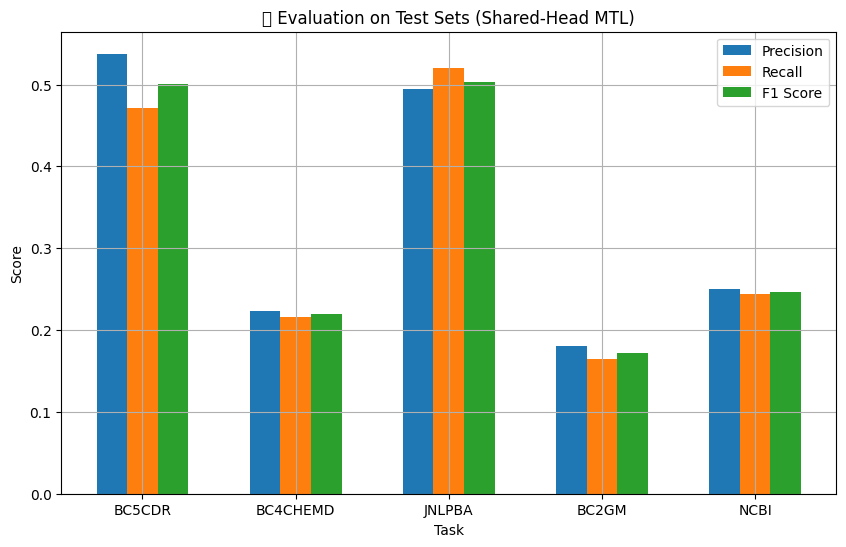

In [10]:
# Load test sets
# def load_test_sets(base_path="/content"):
#     return {name: read_ner_tsv(f"{base_path}/{name}-IOBES/test.tsv") for name in ["BC5CDR", "BC4CHEMD", "NCBI", "JNLPBA","BC2GM"]}
def load_test_sets(base_path="/content"):
    test_sets = {}
    for name in ["BC5CDR", "BC4CHEMD", "JNLPBA", "BC2GM"]:
        test_sets[name] = read_ner_tsv(f"{base_path}/{name}-IOBES/{name}-IOBES/test.tsv")

    # NCBI has a specific naming convention
    test_sets["NCBI"] = read_ner_tsv(f"{base_path}/NCBI-IOBES/NCBI-disease-IOBES/test.tsv")

    return test_sets

def tokenize_test_set(test_data):
    dataset = Dataset.from_dict(test_data)
    return dataset.map(tokenize_and_align_labels, batched=True)

test_sets = load_test_sets()
tokenized_test_sets = {k: tokenize_test_set(v) for k, v in test_sets.items()}

def evaluate_model_on_testset(task_name, raw_data, tokenized_data):
    predictions = trainer.predict(tokenized_data)
    pred_ids = np.argmax(predictions.predictions, axis=2)
    labels = predictions.label_ids
    tokens = raw_data["tokens"]

    pred_labels, true_labels = [], []
    for i in range(len(labels)):
        word_pointer = 0
        p_seq, l_seq = [], []
        for j, label_id in enumerate(labels[i]):
            if label_id == -100: continue
            if word_pointer < len(tokens[i]):
                true_label = id_to_label[label_id]
                pred_label = id_to_label[pred_ids[i][j]]
                l_seq.append(true_label)
                p_seq.append(pred_label)
                word_pointer += 1
        true_labels.append(l_seq)
        pred_labels.append(p_seq)

    y_true = [y for x in true_labels for y in x]
    y_pred = [y for x in pred_labels for y in x]
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    print(f"📊 {task_name} — P: {precision:.2f} R: {recall:.2f} F1: {f1:.2f}")
    return precision, recall, f1

results = {}
for task in test_sets:
    p, r, f1 = evaluate_model_on_testset(task, test_sets[task], tokenized_test_sets[task])
    results[task] = {"precision": p, "recall": r, "f1": f1}

# Plot results
tasks = list(results.keys())
f1s = [results[t]["f1"] for t in tasks]
prec = [results[t]["precision"] for t in tasks]
rec = [results[t]["recall"] for t in tasks]

x = range(len(tasks))
plt.figure(figsize=(10, 6))
plt.bar(x, prec, width=0.2, label='Precision', align='center')
plt.bar([p + 0.2 for p in x], rec, width=0.2, label='Recall', align='center')
plt.bar([p + 0.4 for p in x], f1s, width=0.2, label='F1 Score', align='center')
plt.xticks([p + 0.2 for p in x], tasks)
plt.xlabel("Task")
plt.ylabel("Score")
plt.title("📈 Evaluation on Test Sets (Shared-Head MTL)")
plt.legend()
plt.grid(True)
plt.show()



📊 Span Length Sensitivity for Task: BC5CDR
Length	Prec	Rec	F1	Support
1	0.92	0.80	0.85	18922
2	0.68	0.58	0.63	486
3	0.56	0.59	0.58	243
4+	0.69	0.60	0.64	916


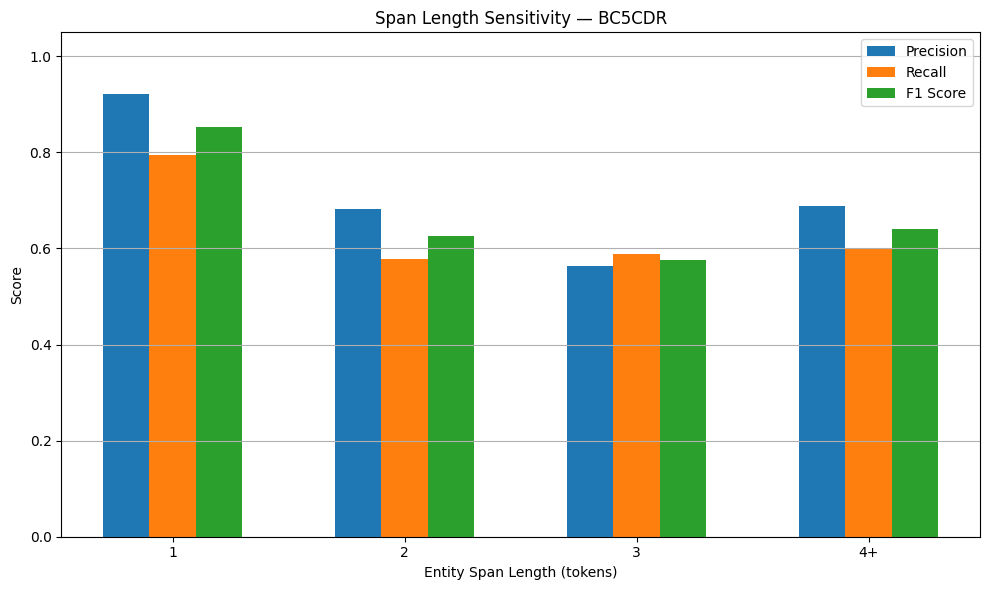


📊 Span Length Sensitivity for Task: BC4CHEMD
Length	Prec	Rec	F1	Support
1	0.83	0.88	0.85	45059
2	0.71	0.88	0.79	1102
3	0.50	0.74	0.60	558
4+	0.78	0.83	0.81	4061


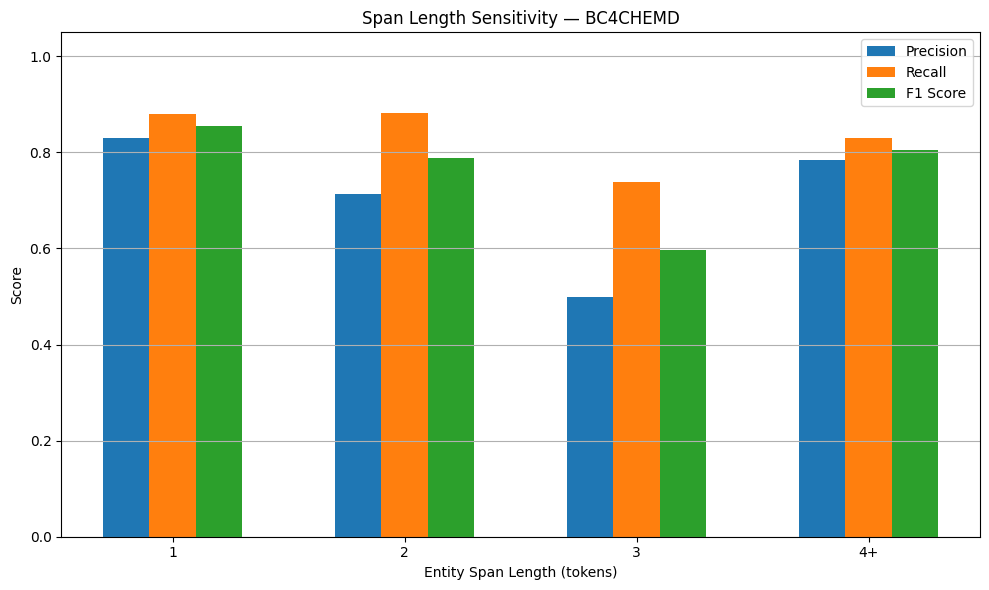


📊 Span Length Sensitivity for Task: JNLPBA
Length	Prec	Rec	F1	Support
1	0.73	0.84	0.78	13907
2	0.72	0.80	0.76	1222
3	0.70	0.78	0.74	589
4+	0.68	0.67	0.68	1503


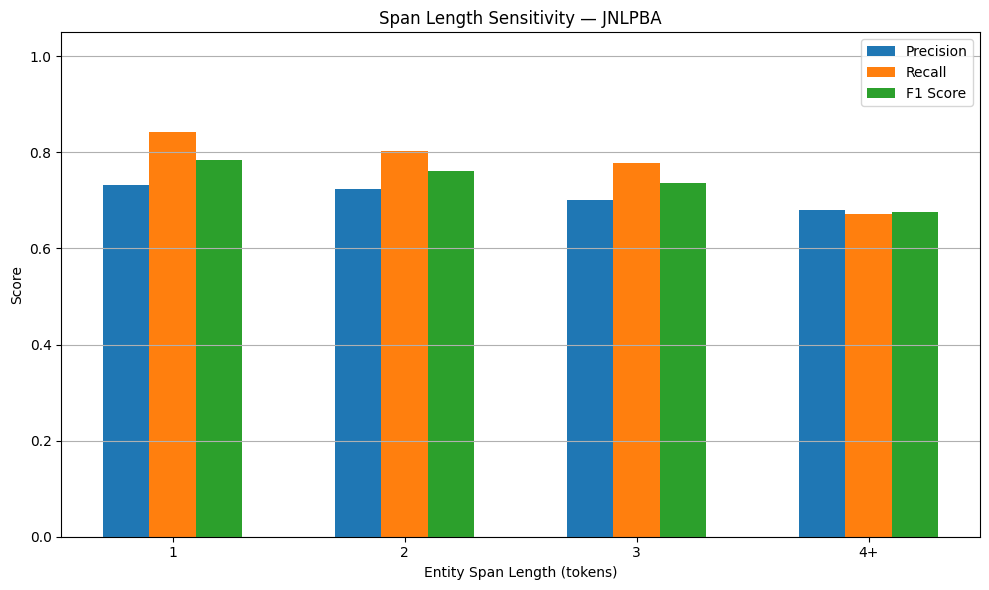


📊 Span Length Sensitivity for Task: BC2GM
Length	Prec	Rec	F1	Support
1	0.67	0.78	0.72	9206
2	0.63	0.70	0.66	576
3	0.70	0.76	0.73	606
4+	0.61	0.64	0.63	1416


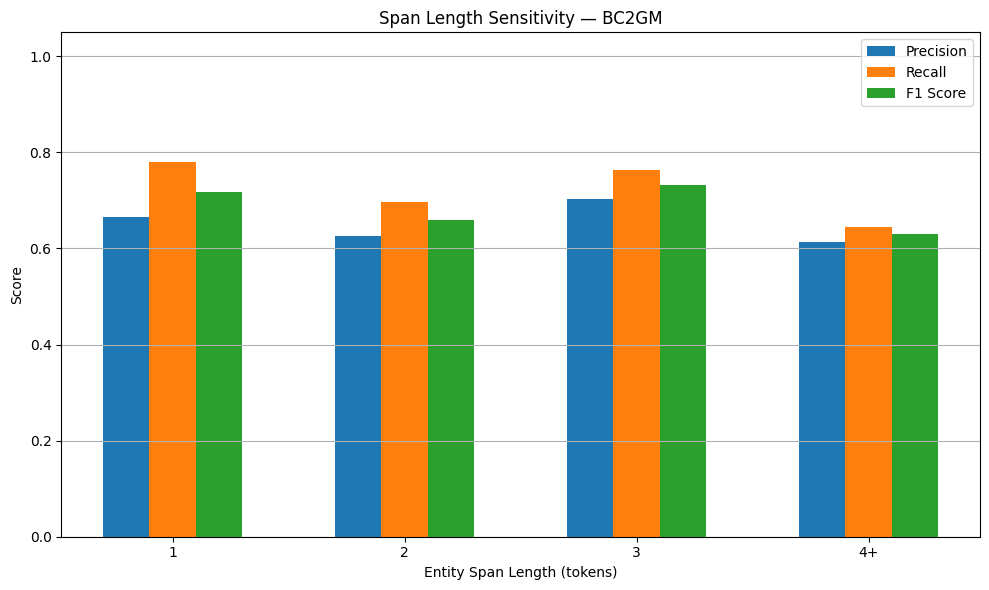


📊 Span Length Sensitivity for Task: NCBI
Length	Prec	Rec	F1	Support
1	0.68	0.83	0.75	1200
2	0.66	0.87	0.75	92
3	0.53	0.73	0.62	63
4+	0.67	0.80	0.73	192


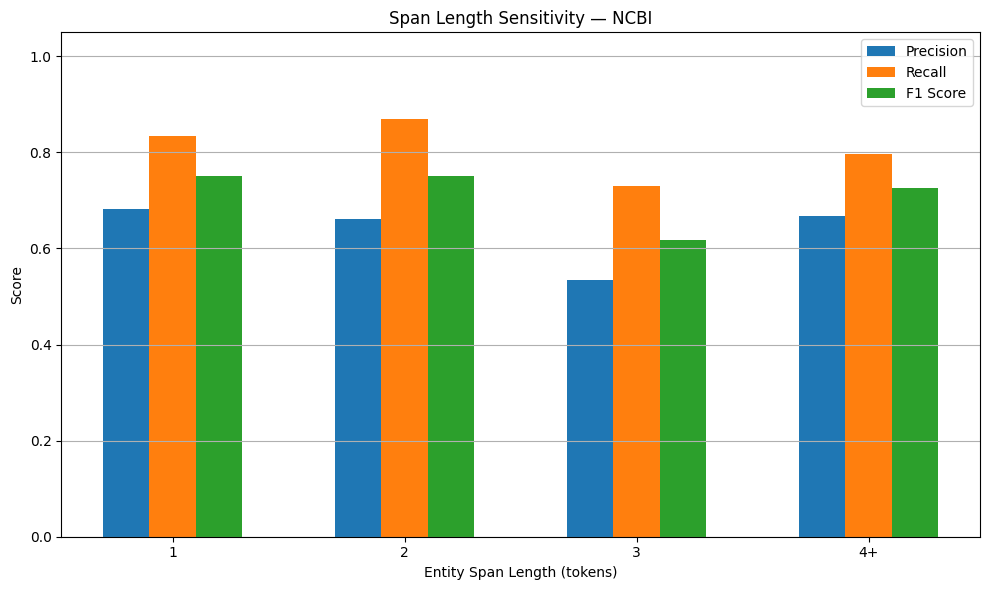

In [11]:
# 📏 Span-Length Sensitivity Analysis

def extract_spans(tokens, labels):
    spans = []
    current = []
    current_type = None
    for i, label in enumerate(labels):
        if label.startswith("B-"):
            if current:
                spans.append((" ".join(current), len(current), current_type))
            current = [tokens[i]]
            current_type = label[2:]
        elif label.startswith("I-") or label.startswith("E-"):
            current.append(tokens[i])
        elif label.startswith("S-"):
            spans.append((tokens[i], 1, label[2:]))
            current = []
        else:
            if current:
                spans.append((" ".join(current), len(current), current_type))
                current = []
    if current:
        spans.append((" ".join(current), len(current), current_type))
    return spans

def span_length_evaluation(task_name, raw_data, tokenized_data):
    predictions = trainer.predict(tokenized_data)
    pred_ids = np.argmax(predictions.predictions, axis=2)
    labels = predictions.label_ids
    tokens_list = raw_data["tokens"]

    true_labels_list, pred_labels_list = [], []

    for i in range(len(labels)):
        word_pointer = 0
        p_seq, l_seq = [], []
        for j, label_id in enumerate(labels[i]):
            if label_id == -100: continue
            if word_pointer < len(tokens_list[i]):
                l_seq.append(id_to_label[label_id])
                p_seq.append(id_to_label[pred_ids[i][j]])
                word_pointer += 1
        true_labels_list.append(l_seq)
        pred_labels_list.append(p_seq)

    length_bins = [1, 2, 3, '4+']
    true_by_len = defaultdict(set)
    pred_by_len = defaultdict(set)

    for idx in range(len(tokens_list)):
        true_spans = extract_spans(tokens_list[idx], true_labels_list[idx])
        pred_spans = extract_spans(tokens_list[idx], pred_labels_list[idx])

        for span in true_spans:
            l = span[1]
            bin_key = l if l <= 3 else '4+'
            true_by_len[bin_key].add((idx, span[0], span[2]))

        for span in pred_spans:
            l = span[1]
            bin_key = l if l <= 3 else '4+'
            pred_by_len[bin_key].add((idx, span[0], span[2]))

    # Metrics per span length
    print(f"\n📊 Span Length Sensitivity for Task: {task_name}")
    print("Length\tPrec\tRec\tF1\tSupport")
    precs, recs, f1s = [], [], []
    for bin_key in length_bins:
        gold = true_by_len[bin_key]
        pred = pred_by_len[bin_key]
        tp = len(gold & pred)
        fp = len(pred - gold)
        fn = len(gold - pred)

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        support = len(gold)
        precs.append(precision)
        recs.append(recall)
        f1s.append(f1)
        print(f"{bin_key}\t{precision:.2f}\t{recall:.2f}\t{f1:.2f}\t{support}")

    # Plot
    x = range(len(length_bins))
    plt.figure(figsize=(10, 6))
    plt.bar(x, precs, width=0.2, label='Precision', align='center')
    plt.bar([p + 0.2 for p in x], recs, width=0.2, label='Recall', align='center')
    plt.bar([p + 0.4 for p in x], f1s, width=0.2, label='F1 Score', align='center')
    plt.xticks([p + 0.2 for p in x], [str(l) for l in length_bins])
    plt.xlabel("Entity Span Length (tokens)")
    plt.ylabel("Score")
    plt.title(f"Span Length Sensitivity — {task_name}")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 🔁 Run span analysis per task
for task in test_sets:
    span_length_evaluation(task, test_sets[task], tokenized_test_sets[task])
